# Week 5:  "Building a Sample for Citizen Science with Galaxy Zoo"

The SDSS records colors, redshifts, magnitudes, and more for millions of objects in the sky.  You might wonder what a sample selected in a particular way (e.g., by color) "looks like".  For instance, are blue galaxies characterized by a particular shape?  

In this activity, we will walk through the basic steps required to select a sample of galaxies from the SDSS database, save their images to your SciDrive, and upload them into your own unique citizen science project on [Zooniverse](http://zooniverse.org).  We will then build a basic project to enable your friends and family to help contribute to answering a science question of your choosing.



## I. Importing SciServer and other important libraries
The SciServer team has written a number of libraries, generally prefixed with "SciServer", that assist in various functions. As with all Python libraries, they must be actively imported before being used.
The next code block imports those, together with some standard Python libraries helpful for scientific analysis. The code block below applies some settings you may find helpful.

In [1]:
# Steps to mount Drive to Google Colab
# 1. Run this script
# 2. Click the link in the output of the script.
# 3. Sign in with your Google account.
# 4. Copy the code from the new page and go back to this page.
# 5. Enter the code in the box and press ENTER
# 6. Wait for the cell to output "Mounted at /content/drive"

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Go to the appropriate folder for execution.
!python3 --version
!cd /content/drive/MyDrive/zooniverseTutorial; pwd; pip3 install -r requirements.txt

Python 3.7.10
/content/drive/MyDrive/zooniverseTutorial
  Using cached https://files.pythonhosted.org/packages/1b/f8/4690523783691ed816b3469c3ec611af3798594d37ade510dd918d59f57e/astroquery-0.4.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/55/6d/09aee478aedcbdc87825eb39bb8593392dc1743b3066d25ba9ec35aa75b0/panoptes_client-1.3.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/a8/04/377418ac1e530ce2a196b54c6552c018fdf1fe776718053efb1f216bffcd/simplejson-3.17.2-cp37-cp37m-manylinux2010_x86_64.whl
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51kB 3.4MB/s 
     |████████████████████████████████| 3.2MB 9.0MB/s 
  Created wheel for redo: filename=redo-2.0.4-cp37-none-any.whl size=11931 sha256=4f19cda5f4d77358115ab537c0d52525ff63d444f8fbd0c14a25463d03947800
  Stored in directory: /root/.cache/pip/wheels/7e/ca/39/576f2d470fab4725bb098ca3a1889ee54

In [4]:
# Import other libraries for use in this notebook.
import os  
import sys
import time
import numpy as np                  # standard Python lib for math ops
from imageio import imsave       # save images as files
import pandas                       # data manipulation package
import matplotlib.pyplot as plt     # another graphing package
import glob
from astropy.table import Table
print('Supporting libraries imported')

# Apply some special settings to the imported libraries
# ensure columns get written completely in notebook
pandas.set_option('display.max_colwidth', -1)
# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')
print('Settings applied')

Supporting libraries imported
Settings applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  from ipykernel import kernelapp as app


In [5]:
# Import Python libraries to work with SciServer
if not '/content/drive/MyDrive/zooniverseTutorial/' in sys.path:
    sys.path.insert(1, '/content/drive/MyDrive/zooniverseTutorial/')
if not '/content/drive/MyDrive/zooniverseTutorial/SciServer' in sys.path:
    sys.path.insert(1, '/content/drive/MyDrive/zooniverseTutorial/SciServer')
if not '/content/drive/MyDrive/zooniverseTutorial/zooniversePackage' in sys.path:   
    sys.path.insert(1, '/content/drive/MyDrive/zooniverseTutorial/zooniversePackage')
print(sys.path)
import CasJobs
import SkyServer
import SciDrive # query with CasJobs
print('SciServer libraries imported')

['', '/content/drive/MyDrive/zooniverseTutorial/zooniversePackage', '/content/drive/MyDrive/zooniverseTutorial/SciServer', '/content/drive/MyDrive/zooniverseTutorial/', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']
SciServer libraries imported


## II. Querying an astronomy database (SDSS DR16)
The next code block searches the SDSS Data Release 16 database via the CasJobs REST API. The query completes quickly, so it uses CasJobs quick mode.
CasJobs also has an asynchronous mode, which will submit job to a queue and will store the results in a table in your MyDB. If your results are very large, it will store the results in MyScratchDB instead.
Run the code block below to query DR16. Try changing some of the query parameters in step to see the effect on the results returned.
Documentation on the SciServer Python libraries can be found at our documentation site at:
http://www.sciserver.org/docs
make example with batch query mode.

An extensive tutorial on how to query the SDSS database can be found here:
http://skyserver.sdss.org/dr16/en/help/howto/search/searchhowtohome.aspx

In [6]:
# Find objects in the Sloan Digital Sky Survey's Data Release 16.
#
# Query the Sloan Digital Sky Serveys' Data Release 16.
# For the database schema and documentation see http://skyserver.sdss.org/dr16
#
# This query finds "a 4x4 grid of nice-looking galaxies": 
#   galaxies in the SDSS database that have a spectrum 
#   and have a size (petror90_r) larger than 10 arcsec.
# 
# First, store the query in an object called "query"
query="""
SELECT TOP 16 p.objId,p.ra,p.dec,p.petror90_r, p.g, p.r
  FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.u BETWEEN 0 AND 19.6
  AND p.g BETWEEN 0 AND 17  AND p.petror90_r > 10
"""
gals = CasJobs.executeQuery(query, "dr16")
gals = gals.set_index('objId')
gals

,ra,dec,petror90_r,g,r
objId,,,,,
1237667781238456442,219.577525,17.609425,18.30117,15.18190,14.29627
1237654879665324133,219.578818,3.639681,10.83427,15.93781,15.30992
1237662264855625968,219.580353,9.291655,10.88518,16.84558,15.97781
1237661850943947119,219.585008,39.393224,14.90473,16.72122,16.38783
1237662264855625834,219.588623,9.227637,14.91277,15.31813,14.61456
1237665351318503492,219.591756,27.336304,17.26094,15.94505,15.18246
1237665532251013352,219.592920,23.428761,14.47842,15.66112,14.86994
1237667781775327268,219.594953,18.111218,12.58201,15.60288,14.90701
1237654879128453333,219.614435,3.274918,11.88382,16.46257,16.06645


#### EXPERIMENT:  What happens if you change the query?

Try changing the query in the following ways: 
- Return 24 matching objects insetad of 16.
- Select only nearby galaxies (redshift < 0.05).
- Select only galaxies likely to be spirals (with u-r color >= 2.22)
- Search for galaxies in SDSS Data Release 14 instead of DR16.

What changes do you notice in the table of returned results?

Try it in the code block below:

In [7]:
# Find objects in the Sloan Digital Sky Survey's Data Release 14.
# First, store the query in an object called "query"
query="""
SELECT TOP 24 p.objId,p.ra,p.dec,p.petror90_r, p.g, p.r
  FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.u BETWEEN 0 AND 19.6
  AND p.g BETWEEN 0 AND 17
  AND p.petror90_r > 10
  AND s.z <0.05
  AND p.u-p.r>=2.2
"""
gals = CasJobs.executeQuery(query, "dr14")
gals = gals.set_index('objId')
gals

,ra,dec,petror90_r,g,r
objId,,,,,
1237648721752621257,145.800180,0.414172,19.92908,15.42035,14.50936
1237648722288574515,143.663829,0.688079,13.57360,15.58319,14.66213
1237648703515590916,211.355248,-0.811343,12.65598,15.63820,14.85252
1237648720149217569,162.289475,-0.908549,11.28101,16.83642,15.95352
1237648721220862132,157.469331,-0.174376,14.83585,15.84306,14.94349
1237648722289623054,146.020908,0.733552,15.45528,15.34520,14.35107
1237648721221189764,158.198549,-0.204757,13.98573,16.24017,15.49375
1237648722289950774,146.806815,0.665611,13.62758,15.63673,14.61840
1237648721221910580,159.835214,-0.200242,27.12333,13.46948,12.64379


# III. Visualizing the Data
Now that we have run the query and stored the results, we can start analyzing the results.

Start by making a simple plot of positions, using the default query from the previous code block (select top 16... AND p.petror90_r > 10).

What do you see?

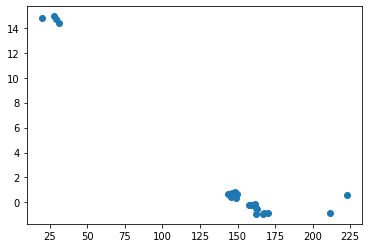

In [8]:
# Try making an Ra, Dec scatter plot...

plt.scatter(gals['ra'], gals['dec'])
plt.show() 

#### EXPERIMENT: How can you improve the graph?

The graph you just made visualizes your data in the simplets possible way: as a scatterplot of (ra/dec) positions with default graphing parameters. But you could make many other possible graphs, and you can always add labels, change axis scales, or adjust many other features of graphs. You practiced making some of these display changes in the sections above. Full details on all the possible graph options are described in the online documentation for the pyplot module at http://matplotlib.org/api/pyplot_summary.html.


Try changing the code block below in the following ways. What changes do you notice in the plot?
- Add axis labels
- Increase the font size of the numbers and the axis labels
- Add a title above the graph
- Crop the range of the plot to show only values with abs(Dec) < 5

Next, try making some other plots. Add any labels and titles that will help the reader interpret your graphs.
- Plot a histogram of the g-band magnitudes
- Plot a color-magnitude diagram (e.g., g-r vs. r)
- Create graphs with 1,000 objects instead of just 16 (note this will require changing the query above and re-running both blocks)

Try it in the code blocks below:

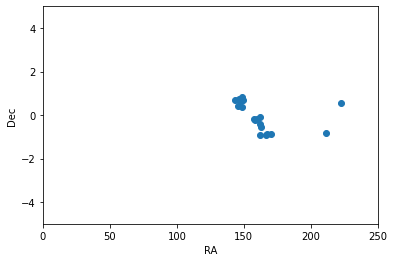

In [9]:
# make scatterplot
#plt.scatter(gals['g'],gals['r'])

# create an overall figure object (fig) and an "axis" object to display this data (ax)
fig, ax = plt.subplots()

# This graph is associated with the axis object
ax.scatter(gals['ra'], gals['dec'])

# Add formatting options here. Some may apply to fig and others to ax.
plt.ylabel('Dec')
plt.xlabel('RA')
plt.axis([0,250,-5,5])

# Show the graph will all the options you set.
plt.show()

Text(0, 0.5, 'Number')

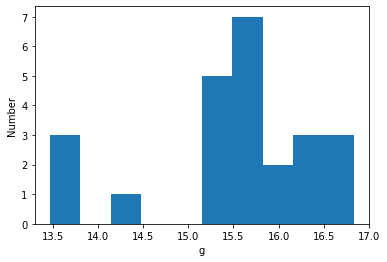

In [10]:
plt.hist(gals['g'])
plt.xlabel('g')
plt.ylabel('Number')

Text(0, 0.5, 'g-r')

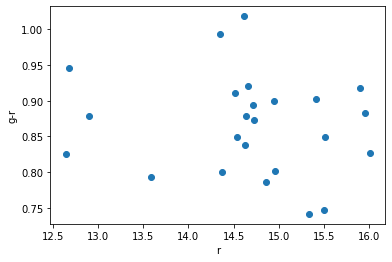

In [11]:
gr = gals['g']-gals['r']
plt.scatter(gals['r'], gr)
plt.xlabel('r')
plt.ylabel('g-r')

# IV. Store results in your container for later use
The next code block saves the data table "gals" as an HD5 file and as a CSV file.

To see these files, go back to your iPython notebook dashboard (the page from which you opened this notebook). Make sure you are in the persistent folder. You should see your files there. Click on the file names to preview.


In [12]:
# store result as HDF5 file 
h5store = pandas.HDFStore('GalaxyThumbSample.h5')
h5store['galaxies']=gals
h5store.close()

# store result as CSV file
gals.to_csv('GalaxyThumbSample.csv')

print ("Done.")

Done.



# V. Retrieve thumbnail cutouts of galaxies and show them on screen
SkyServer has a service that will produce a color image cutout of certain dimensions around a specified position, displayed as a JPG thumbnail.

The code below iterates through each galaxy in your results and calls the image cutout generator for each galaxy. The scale of the image depends on the Petrosian radius of the galaxy.

Getting image 1 of 24...
Getting image 2 of 24...
Getting image 3 of 24...
Getting image 4 of 24...
Getting image 5 of 24...
Getting image 6 of 24...
Getting image 7 of 24...
Getting image 8 of 24...
Getting image 9 of 24...
Getting image 10 of 24...
Getting image 11 of 24...
Getting image 12 of 24...
Getting image 13 of 24...
Getting image 14 of 24...
Getting image 15 of 24...
Getting image 16 of 24...
Getting image 17 of 24...
Getting image 18 of 24...
Getting image 19 of 24...
Getting image 20 of 24...
Getting image 21 of 24...
Getting image 22 of 24...
Getting image 23 of 24...
Getting image 24 of 24...
Plotting images...


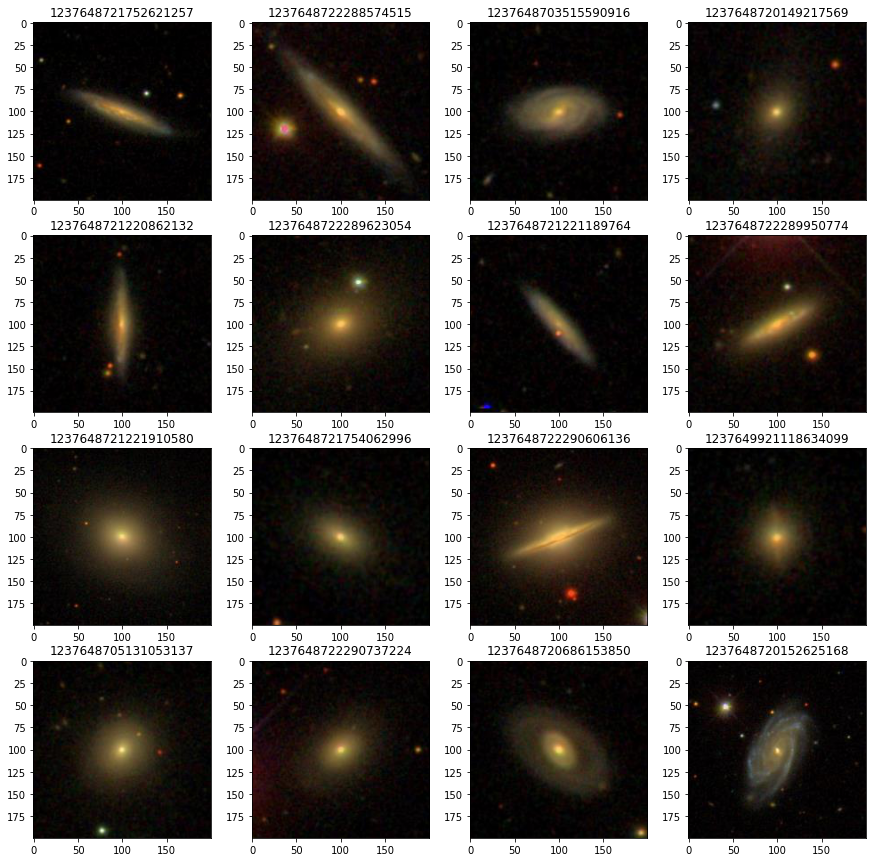

In [13]:
# set thumbnail parameters
width=200           # image width
height=200          # height
pixelsize=0.396     # image scale
plt.figure(figsize=(15, 15))   # display in a 4x4 grid
subPlotNum = 1

i = 0
nGalaxies = len(gals)
for index,gal in gals.iterrows():           # iterate through rows in the DataFrame
    i = i + 1
    print('Getting image '+str(i)+' of '+str(nGalaxies)+'...')
    if (i == nGalaxies):
        print('Plotting images...')
    scale=2*gal['petror90_r']/pixelsize/width
    img = SkyServer.getJpegImgCutout(ra=gal['ra'], dec=gal['dec'], width=width, height=height, scale=scale,dataRelease='DR16')
    
    # Preview the first 16 with this command
    if i < 17:
        plt.subplot(4,4,subPlotNum)
    
    ## Preview the full sample of the galaxies by un-commenting the following command:
    #plt.subplot(int(len(gals)/4)+1,4,subPlotNum)
    
    subPlotNum += 1
    plt.imshow(img)                               # show images in grid
    plt.title(index)                            # show the object identifier (objId) above the image.

plt.show()

# VI. Write thumbnails to SciDrive
SciDrive is the newest component of SciServer. It allows you to save query results as flat files in a Dropbox-like interface you can access anywhere.

For boring technical reasons, the version of SciDrive this notebook connects to is not the same as the pre-production version you may have used before. Use the link below to access this test version of SciDrive. You should have no containers in this SciDrive yet.

Check your test SciDrive at:
https://www.scidrive.org/scidrive/

If the above link does not show a proper view of scidrive, with folders etc., please let us know, and do not run the rest of the code in this notebook until we investigate.

The three code blocks below work together to write the thumbnails you generated in step 6 into your test SciDrive.

In [18]:
'''IF YOU GET A 500 ERROR, TRY THIS AGAIN. 500 ERROR IMPLIES THERE WAS SOME ISSUE CONNECTING TO SCIDRIVE, THUS TRYING THIS A SECOND 
TIME SHOULD PROPERLY CONNECT'''

# Step 7b: Specify the directory in your SciDrive to hold the thumbnail images
mydir = '/content/drive/MyDrive/zooniverseTutorial/subjects'

# Makes a new local directory if there is no local directory named 'week5'
if not os.path.isdir(mydir):
    os.mkdir(mydir)
else:
    for f in glob.glob(mydir+'/*'):
        os.remove(f)

# if that directory already exists, delete it before trying to create it again.
'''directories_dict = SciDrive.directoryList()
for x in directories_dict['contents']:
    if (x['path'][1:] == mydir):
        SciDrive.delete(x['path']) '''    

# create that directory in your SciDrive
#SciDrive.createContainer(mydir)
#print('Created SciDrive directory: ',mydir,'\n')

# set thumbnail parameters
width=200           # image width
height=200          # height
pixelsize=0.396     # image scale
        
# make a name for your "manifest" -- the table that matches your images to known information about the galaxies
fout = open(mydir+'/galaxy_manifest.csv', 'w')
fout.write("index, image, ra, dec \n")

# Write thumbnails to SciDrive. You will see a confirmation message when each is written
i = 0
puburls=[]
localArray = []
for index,gal in gals.iterrows():   
    i = i + 1
    print('Writing image file '+str(i)+' of '+str(len(gals))+'...')
    scale=2*gal['petror90_r']/pixelsize/width
    img = SkyServer.getJpegImgCutout(ra=gal['ra'], dec=gal['dec'], width=width, height=height, scale=scale,dataRelease='DR14')
    localname = str(index)+'.jpg'
    scidrivename = mydir+"/"+localname
    localpath = mydir+'/'+str(index)+'.jpg'
    # Here the file gets uploaded to the container 
    imsave(localpath,img)
    localArray.append(localpath)
    #SciDrive.upload(scidrivename, localFilePath=localpath)
    #puburls.append(SciDrive.publicUrl(scidrivename))
    #fout.write('{0:19.0f}, {1:.0f}.jpg, {2:.6f}, {3:.6f}\n'.format(index,index,gal['ra'],gal['dec']))
    fout.write('{}, {}.jpg, {}, {}\n'.format(index,index,gal['ra'],gal['dec']))
fout.close()

#gals['pubURL']=puburls

print('\nWriting manifest...\n')
#SciDrive.upload(mydir+'/galaxy_manifest.csv', localFilePath = './'+mydir+'/galaxy_manifest.csv')

print('Done!')

Writing image file 1 of 24...
Writing image file 2 of 24...
Writing image file 3 of 24...
Writing image file 4 of 24...
Writing image file 5 of 24...
Writing image file 6 of 24...
Writing image file 7 of 24...
Writing image file 8 of 24...
Writing image file 9 of 24...
Writing image file 10 of 24...
Writing image file 11 of 24...
Writing image file 12 of 24...
Writing image file 13 of 24...
Writing image file 14 of 24...
Writing image file 15 of 24...
Writing image file 16 of 24...
Writing image file 17 of 24...
Writing image file 18 of 24...
Writing image file 19 of 24...
Writing image file 20 of 24...
Writing image file 21 of 24...
Writing image file 22 of 24...
Writing image file 23 of 24...
Writing image file 24 of 24...

Writing manifest...

Done!


# Uploading your data to Zooniverse

Your thumbnails will now be collected in your SciDrive.  You can find them and download them locally.  You will also need to download your "manifest" (the comma-separated value ".csv" file that matches your images to the known properties of the galaxies.  This should have been saved in the same same SciDrive directory as your images.  It will make the procedure easier if you download the manifest and thumbnail images into the same local directory, so thta you can upload them to Zooniverse at the same time.

If you haven't already, you'll now need to make an account on [Zooniverse](https://www.zooniverse.org/).

Once you're signed on to your account, click on [Build a Project](https://www.zooniverse.org/lab), and follow along with the [tutorial](https://help.zooniverse.org/getting-started/)!

In [20]:
import getpass
#import io
#from PIL import Image

#files = SciDrive.directoryList(mydir)
#print(files)
#byteArray = []

print('Enter your Zooniverse username and password')

username = input('Username: ')
password = getpass.getpass('Password: ')

print('Welcome ' + username)

import zooniverseScripts as zooni

projectName = 'Zooniverse Tutorial Project ???? for  '+ username
imgLoc = [mydir]

zooni.run(username, password, projectName, imgLoc, tutorial=True)

Enter your Zooniverse username and password
Username: oostoos3
Password: ··········
Welcome oostoos3
--- --- --- ---
Establishing connection to Zooniverse and creating project
Attempting connection.
<Response [200]>
Project successfully created.
/content/drive/MyDrive/zooniverseTutorial/subjects/1237648721752621257.jpg
/content/drive/MyDrive/zooniverseTutorial/subjects/1237648722288574515.jpg
/content/drive/MyDrive/zooniverseTutorial/subjects/1237648703515590916.jpg
/content/drive/MyDrive/zooniverseTutorial/subjects/1237648720149217569.jpg
/content/drive/MyDrive/zooniverseTutorial/subjects/1237648721220862132.jpg
/content/drive/MyDrive/zooniverseTutorial/subjects/1237648722289623054.jpg
/content/drive/MyDrive/zooniverseTutorial/subjects/1237648721221189764.jpg
/content/drive/MyDrive/zooniverseTutorial/subjects/1237648722289950774.jpg
/content/drive/MyDrive/zooniverseTutorial/subjects/1237648721221910580.jpg
/content/drive/MyDrive/zooniverseTutorial/subjects/1237648721754062996.jpg
/con